# OASIS toy experiments

Comparing (stochastic) gradient descent with OASIS on a few toy problems -- the first steps in the preconditioned SGD project.

OASIS implemented from Jahani et al., 2021.

https://arxiv.org/pdf/2109.05198.pdf

In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
from jax import random
from jax import jvp, grad
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from simplecryoem.optimization import (
    sgd,
    oasis_adaptive
)
from simplecryoem.optimization import precon_sgd as oasis
from simplecryoem.optimization import conjugate_gradient as cg

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

#### Hutchinson's method

In [3]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

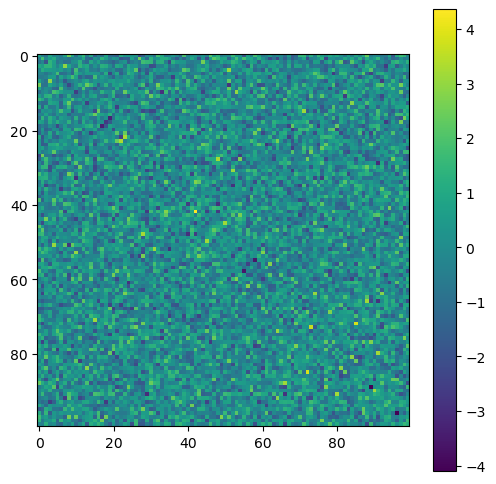

In [4]:
key, subkey = random.split(key)

A = random.normal(subkey, (n, n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A))
plt.colorbar()

In [5]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

# z * A @ z

In [6]:
zAz = jax.vmap(lambda zi: zi * (A @ zi))(z)
# plt.imshow(zAz)

In [7]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i - 1] + zAz[i]

for i in range(1, iters):
    d[i] = d[i] / (i + 1)

In [8]:
err = jnp.mean((d - jnp.diag(A)) ** 2, axis=1)

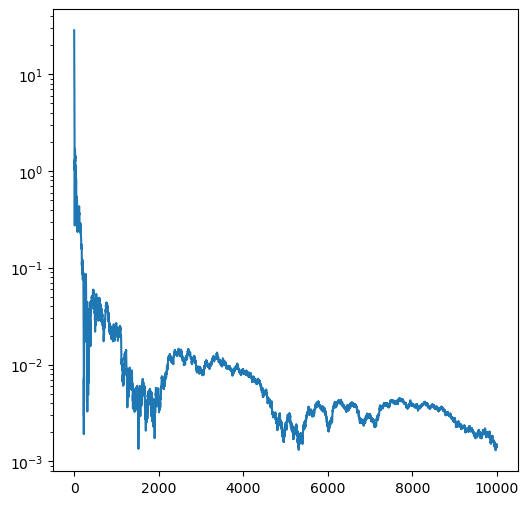

In [9]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [10]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [11]:
b = A @ x0
f = lambda x: jnp.real(jnp.mean(jnp.conj(A @ x - b) * (A @ x - b)))

In [12]:
# Naive
def hvp0(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)


# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [13]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1 - v2))

4.27 ms ± 96.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.63 ms ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Array(0., dtype=float64)

#### Toy problem

Condition number =  3.33e+05


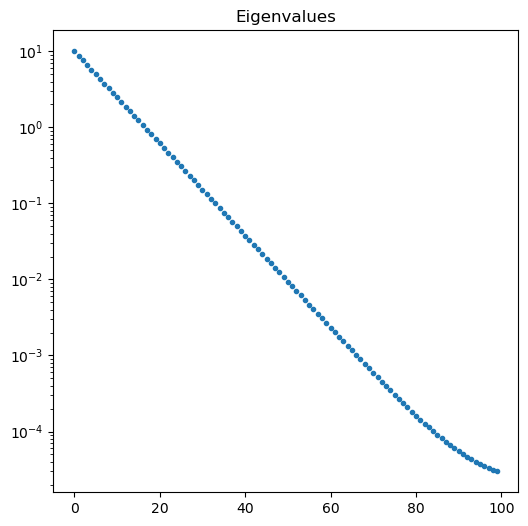

In [14]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n, n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5, 1, n))
d = d + jnp.abs(jnp.min(d) * 2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert jnp.sum(evals < 0) == 0
assert jnp.max(jnp.imag(evals)) < 1e-12
# assert(jnp.max(jnp.abs(A.T - A)) == 0)
# assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, ".")
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [15]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(
    lambda x: jnp.real(
        jnp.mean(jnp.conj(A @ x - b) * (A @ x - b)) + lam * jnp.mean(jnp.conj(x) * x)
    )
)
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
# hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v: hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
# print(f"hessianF(x_gt) = {hessianF(x_gt)}")

f(x_gt + 1) = 3.8184397759557154
f(x_gt) = 1.0999160135623296
gradF(x_gt) = [ 0.02483139-1.26239232e-03j  0.00131171+1.18908501e-04j
 -0.00805092+1.40325802e-03j  0.0731966 -1.93936552e-03j
 -0.00366491+3.54372417e-03j  0.00871001-8.37081856e-04j
 -0.03767206+1.92694621e-03j -0.03284158+2.87941424e-04j
 -0.08078347+6.26288355e-04j  0.02791093+9.48995024e-04j
 -0.04808068+3.81237675e-04j  0.05860101-8.68326425e-04j
  0.03579204+1.82987860e-03j  0.00130051+4.62728192e-04j
  0.02454986-6.88713190e-04j -0.00184737-2.58935557e-04j
 -0.00390067+3.23551687e-04j  0.01004639-1.27277471e-03j
 -0.02607775-5.68867878e-04j -0.02615106+1.53674672e-03j
  0.00898083+2.40444300e-03j  0.0171533 -3.31242936e-04j
  0.03680069-4.59740325e-04j  0.01576381+3.84879079e-04j
  0.00246272-6.45646765e-04j  0.02060109+7.14045657e-05j
  0.02372031-4.01833260e-03j  0.00575355-8.58267701e-04j
  0.00716577-5.29815251e-04j -0.04474034-3.99037067e-04j
 -0.08693843-3.13555940e-04j -0.00995814+1.38231598e-03j
  0.00877281

In [16]:
def gd(F, gradF, eta, w0, N_iter=20, iter_display=1):
    loss = []
    for k in range(1, N_iter + 1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)

        w0 = w1

        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")

    return w1, jnp.array(loss)


def newton(F, gradF, hessianF, w0, N_iter=20, iter_display=1):
    loss = []
    for k in range(1, N_iter + 1):
        G = gradF(w0)
        H = hessianF(w0)

        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)

        w0 = w1

        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")

    return w1, jnp.array(loss)

In [17]:
N_iter = 1000
eta = 1e-3  # 0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display=200)

Iter 200: loss = 5.369683148196936
Iter 400: loss = 4.753385110733972
Iter 600: loss = 4.324018561756503
Iter 800: loss = 4.018074738302466
Iter 1000: loss = 3.795607485021778


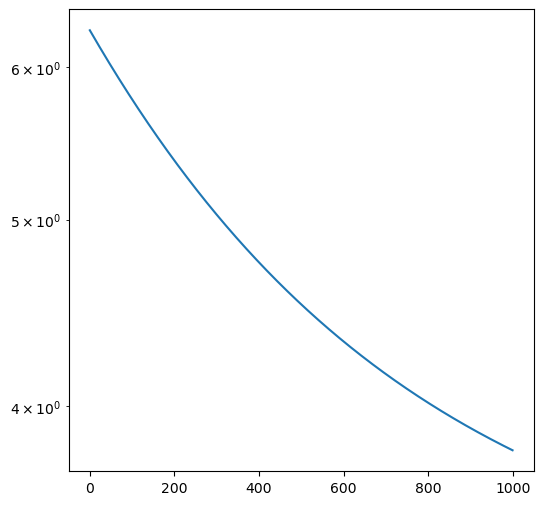

In [18]:
plt.semilogy(loss_gd)

In [19]:
# N_iter = 10

# x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [20]:
# plt.plot(loss_n)

In [21]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv: jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

  cg iter 0 ||r|| = 0.9423348606990324
  cg iter 10 ||r|| = 0.0504254504894211
  cg iter 20 ||r|| = 0.019682041492226278
  cg iter 30 ||r|| = 0.0002659656625845928
  cg iter 40 ||r|| = 7.134133808267531e-06
  cg iter 50 ||r|| = 3.621036097669409e-07
  cg iter 60 ||r|| = 3.901740622936727e-08
  cg iter 70 ||r|| = 2.0180978126658987e-09
  cg iter 80 ||r|| = 5.646119629960297e-11
  cg iter 90 ||r|| = 1.613548374320412e-11
  cg iter 100 ||r|| = 1.9728902277837833e-12
  cg iter 110 ||r|| = 3.508436223999118e-13
  cg iter 120 ||r|| = 1.4869200417963864e-13
  cg iter 130 ||r|| = 4.223370722847853e-14
  cg iter 140 ||r|| = 4.8889006987170953e-14
  cg iter 150 ||r|| = 1.0294241434983035e-13
  cg iter 160 ||r|| = 3.748481881747975e-14
  cg iter 170 ||r|| = 2.8130371863253652e-14
  cg iter 180 ||r|| = 4.4639236461804694e-14
  cg iter 190 ||r|| = 2.8180330827210984e-14
  cg iter 200 ||r|| = 2.8134348851510735e-14
  cg iter 210 ||r|| = 2.92058975838875e-14
  cg iter 220 ||r|| = 3.283451125858271e-1

In [22]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
# print(F(x_n))

1.0999160135623296
2.7666632515851157
3.795607485021778


#### OASIS

In [23]:
Fidx = jax.jit(lambda x, idx: F(x))
gradFidx = jax.jit(lambda x, idx: jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx: hvp(F, (x,), (v,)))

In [24]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters + 1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)

    zD0z += z * hvpFidx(x0, z, 1)

D0 = jnp.array(zD0z / iters)

# D0exact = jnp.diag(hessianF(x0)) # Cheating a bit

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6645.64it/s]


In [25]:
# plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [26]:
N_iter = 1000
beta2 = 0.99
eta = 0.1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0.1  # 0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(
    subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display=100
)

Epoch 100/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 625.83it/s, eta=1.000e-01, loss=2.842e+00]


  Loss =  2.84177951e+00
  eta = 0.1
  alpha= 0.1
Epoch 200/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 680.67it/s, eta=1.000e-01, loss=2.814e+00]

  Loss =  2.81433165e+00
  eta = 0.1
  alpha= 0.1


Epoch 300/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 466.86it/s, eta=1.000e-01, loss=2.799e+00]


  Loss =  2.79855226e+00
  eta = 0.1
  alpha= 0.1
Epoch 400/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 674.33it/s, eta=1.000e-01, loss=2.788e+00]

  Loss =  2.78841371e+00
  eta = 0.1
  alpha= 0.1


Epoch 500/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 485.68it/s, eta=1.000e-01, loss=2.782e+00]

  Loss =  2.78165948e+00
  eta = 0.1
  alpha= 0.1


Epoch 600/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.02it/s, eta=1.000e-01, loss=2.777e+00]

  Loss =  2.77707520e+00
  eta = 0.1
  alpha= 0.1


Epoch 700/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.67it/s, eta=1.000e-01, loss=2.774e+00]

  Loss =  2.77393441e+00
  eta = 0.1
  alpha= 0.1


Epoch 800/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 652.61it/s, eta=1.000e-01, loss=2.772e+00]

  Loss =  2.77176326e+00
  eta = 0.1
  alpha= 0.1


Epoch 900/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.40it/s, eta=1.000e-01, loss=2.770e+00]

  Loss =  2.77025997e+00
  eta = 0.1
  alpha= 0.1


Epoch 1000/1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 631.29it/s, eta=1.000e-01, loss=2.769e+00]

  Loss =  2.76921585e+00
  eta = 0.1
  alpha= 0.1


In [27]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1  # 0.1/0.001/0.01/0.15

alpha = 0.1  # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta0,
    D0,
    beta2,
    alpha,
    N_iter,
    iter_display=500,
)

Epoch 500/1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 483.05it/s, loss=2.769e+00]

  Loss =  2.769e+00


Epoch 1000/1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 444.26it/s, loss=2.767e+00]

  Loss =  2.767e+00


0.9405524003213058
1.1912727549574869
0.9351301126165555
0.9385105164667499


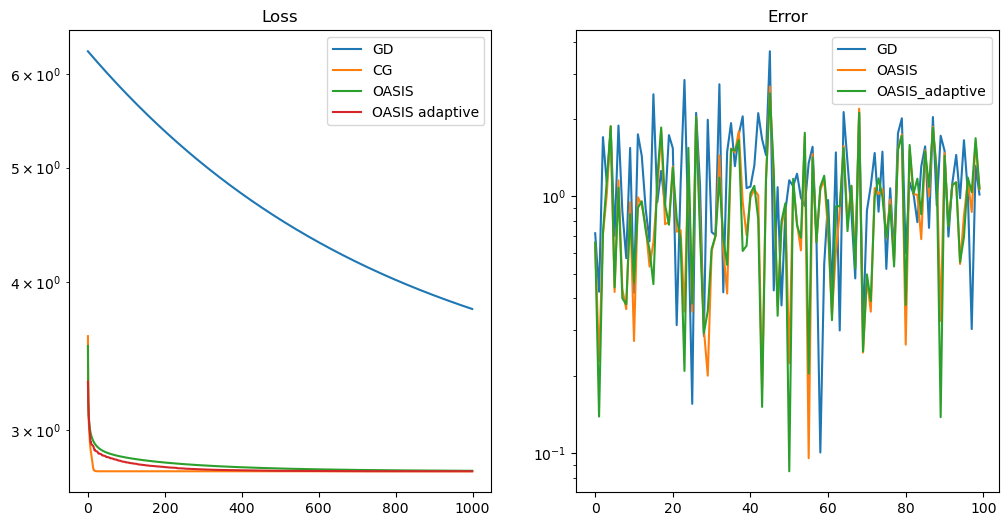

In [28]:
# print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt - x_cg)))
print(jnp.mean(jnp.abs(x_gt - x_gd)))
print(jnp.mean(jnp.abs(x_gt - x_o)))
print(jnp.mean(jnp.abs(x_gt - x_oa)))

plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)

nn0 = 0
nn1 = 1000
# plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
# plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1, 2, 2)
# plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt - x_gd))
plt.semilogy(jnp.abs(x_gt - x_o))
plt.semilogy(jnp.abs(x_gt - x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"] = 6, 6

### Stochastic - sum of operators

In [29]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [30]:
sig_noise = 10
lam = 0.1

In [31]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)

    A = random.normal(subkeys[0], (n, n), dtype=x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)

    d = jnp.logspace(10, -5, n) + random.normal(subkeys[1], (n,), dtype=jnp.double) * 10
    d = d + jnp.abs(jnp.min(d) * 2)

    A = v.T @ jnp.diag(d) @ v
    ops.append(A)

    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype=x_gt.dtype) * sig_noise
    b.append(bn)

    # print(jnp.mean((A@x_gt - bn)**2))

ops = jnp.array(ops)
b = jnp.array(b)

In [32]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

 4.16e+08


In [33]:
print(jnp.max(w))
print(jnp.min(w))

10000000071.396633
24.04885832148026


In [34]:
def loss_term(x, A, b):
    return (
        1
        / 2
        * jnp.real(
            jnp.mean(jnp.conj(A @ x - b) * (A @ x - b))
            + lam * jnp.mean(jnp.conj(x) * x)
        )
    )


def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes=(None, 0, 0))(x, ops, b))


def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)


def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y: grad_loss_func(y, ops, b), (x,), (v,))[1]

In [35]:
idx = np.random.permutation(N)[: N // 3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

52.056552234460156
50.16476461608576
(100,)
(100,)
(100,)
(100,)


In [36]:
key, subkey = random.split(key)

hessianF = lambda x: jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx: loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx: grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx: hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype=x_gt.dtype)

In [37]:
Fidx(x_gt, jnp.arange(N))

Array(50.16476462, dtype=float64)

In [38]:
# D0 = jnp.ones((nx,nx,nx))  #<--- not very good
# D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2 * iters + 1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2 * i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2 * i + 1], N)[:batch_sz]

    zD0z += z * hvpFidx(x0, z, idx)

D0 = jnp.array(zD0z / iters)


# plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 505.59it/s]


In [39]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os, _, _ = oasis(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=20,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.89it/s, eta=1.000e-01, loss=7.391e+14]


  Loss =  8.91575542e+14
  eta = 0.1
  alpha= 0
Epoch 2/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 242.82it/s, eta=1.000e-01, loss=2.456e+12]


  Loss =  2.81824024e+12
  eta = 0.1
  alpha= 0
Epoch 3/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 244.25it/s, eta=1.000e-01, loss=1.272e+10]


  Loss =  1.34941349e+10
  eta = 0.1
  alpha= 0
Epoch 4/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.45it/s, eta=1.000e-01, loss=6.151e+07]


  Loss =  6.63536758e+07
  eta = 0.1
  alpha= 0
Epoch 5/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.98it/s, eta=1.000e-01, loss=3.339e+05]


  Loss =  3.60316376e+05
  eta = 0.1
  alpha= 0
Epoch 6/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 244.56it/s, eta=1.000e-01, loss=1.722e+03]


  Loss =  1.97096333e+03
  eta = 0.1
  alpha= 0
Epoch 7/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 244.40it/s, eta=1.000e-01, loss=5.913e+01]


  Loss =  5.97654083e+01
  eta = 0.1
  alpha= 0
Epoch 8/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.04it/s, eta=1.000e-01, loss=5.026e+01]


  Loss =  5.04742834e+01
  eta = 0.1
  alpha= 0
Epoch 9/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 249.26it/s, eta=1.000e-01, loss=4.754e+01]


  Loss =  5.02539094e+01
  eta = 0.1
  alpha= 0
Epoch 10/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 248.47it/s, eta=1.000e-01, loss=5.057e+01]


  Loss =  5.02701682e+01
  eta = 0.1
  alpha= 0
Epoch 11/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 250.37it/s, eta=1.000e-01, loss=5.044e+01]


  Loss =  5.04119077e+01
  eta = 0.1
  alpha= 0
Epoch 12/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 247.16it/s, eta=1.000e-01, loss=5.008e+01]


  Loss =  5.02754434e+01
  eta = 0.1
  alpha= 0
Epoch 13/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 247.87it/s, eta=1.000e-01, loss=4.889e+01]


  Loss =  5.03074494e+01
  eta = 0.1
  alpha= 0
Epoch 14/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.37it/s, eta=1.000e-01, loss=4.776e+01]


  Loss =  5.02438274e+01
  eta = 0.1
  alpha= 0
Epoch 15/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 250.29it/s, eta=1.000e-01, loss=5.021e+01]


  Loss =  5.02365957e+01
  eta = 0.1
  alpha= 0
Epoch 16/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 248.22it/s, eta=1.000e-01, loss=4.902e+01]


  Loss =  5.02770483e+01
  eta = 0.1
  alpha= 0
Epoch 17/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 246.08it/s, eta=1.000e-01, loss=5.091e+01]


  Loss =  5.02679529e+01
  eta = 0.1
  alpha= 0
Epoch 18/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 249.00it/s, eta=1.000e-01, loss=5.176e+01]


  Loss =  5.03559072e+01
  eta = 0.1
  alpha= 0
Epoch 19/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 250.14it/s, eta=1.000e-01, loss=5.053e+01]


  Loss =  5.02173844e+01
  eta = 0.1
  alpha= 0
Epoch 20/20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 243.89it/s, eta=1.000e-01, loss=4.905e+01]


  Loss =  5.02147437e+01
  eta = 0.1
  alpha= 0


In [40]:
N_epoch = 20
beta2 = 0.99
eta = 0.01  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=20,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 189.42it/s, loss=4.247e+15]


  Loss =  4.375e+15
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 212.13it/s, loss=5.161e+13]


  Loss =  4.378e+13
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 209.99it/s, loss=3.928e+11]


  Loss =  4.425e+11
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.88it/s, loss=1.207e+10]


  Loss =  1.178e+10
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.70it/s, loss=2.044e+08]


  Loss =  2.070e+08
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.35it/s, loss=2.907e+06]


  Loss =  3.419e+06
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 208.66it/s, loss=5.444e+04]


  Loss =  7.977e+04
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 210.02it/s, loss=1.167e+03]


  Loss =  1.369e+03
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 211.89it/s, loss=8.538e+01]


  Loss =  8.863e+01
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 210.56it/s, loss=5.058e+01]


  Loss =  5.097e+01
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 210.23it/s, loss=5.013e+01]


  Loss =  5.019e+01
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 209.21it/s, loss=4.992e+01]


  Loss =  5.024e+01
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 209.62it/s, loss=4.936e+01]


  Loss =  5.017e+01
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 208.88it/s, loss=4.932e+01]


  Loss =  5.016e+01
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 208.54it/s, loss=5.094e+01]


  Loss =  5.015e+01
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 211.68it/s, loss=5.054e+01]


  Loss =  5.018e+01
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.79it/s, loss=4.910e+01]


  Loss =  5.020e+01
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 208.18it/s, loss=4.792e+01]


  Loss =  5.055e+01
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.32it/s, loss=5.025e+01]


  Loss =  5.023e+01
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 204.35it/s, loss=4.973e+01]


  Loss =  5.025e+01


In [41]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o, _, _ = oasis(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=None,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it, eta=1.000e-01, loss=1.406e+18]


  Loss =  1.40577453e+18
  eta = 0.1
  alpha= 0
Epoch 2/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.86it/s, eta=1.000e-01, loss=1.109e+18]


  Loss =  1.10904067e+18
  eta = 0.1
  alpha= 0
Epoch 3/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s, eta=1.000e-01, loss=9.135e+17]


  Loss =  9.13514658e+17
  eta = 0.1
  alpha= 0
Epoch 4/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s, eta=1.000e-01, loss=7.628e+17]


  Loss =  7.62772124e+17
  eta = 0.1
  alpha= 0
Epoch 5/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s, eta=1.000e-01, loss=6.401e+17]


  Loss =  6.40104435e+17
  eta = 0.1
  alpha= 0
Epoch 6/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s, eta=1.000e-01, loss=5.386e+17]


  Loss =  5.38562973e+17
  eta = 0.1
  alpha= 0
Epoch 7/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s, eta=1.000e-01, loss=4.540e+17]


  Loss =  4.53968595e+17
  eta = 0.1
  alpha= 0
Epoch 8/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s, eta=1.000e-01, loss=3.833e+17]


  Loss =  3.83251458e+17
  eta = 0.1
  alpha= 0
Epoch 9/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s, eta=1.000e-01, loss=3.240e+17]


  Loss =  3.24009165e+17
  eta = 0.1
  alpha= 0
Epoch 10/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s, eta=1.000e-01, loss=2.743e+17]


  Loss =  2.74295158e+17
  eta = 0.1
  alpha= 0
Epoch 11/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s, eta=1.000e-01, loss=2.325e+17]


  Loss =  2.32505637e+17
  eta = 0.1
  alpha= 0
Epoch 12/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.84it/s, eta=1.000e-01, loss=1.973e+17]


  Loss =  1.97317427e+17
  eta = 0.1
  alpha= 0
Epoch 13/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s, eta=1.000e-01, loss=1.676e+17]


  Loss =  1.67644703e+17
  eta = 0.1
  alpha= 0
Epoch 14/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.73it/s, eta=1.000e-01, loss=1.426e+17]


  Loss =  1.42588375e+17
  eta = 0.1
  alpha= 0
Epoch 15/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s, eta=1.000e-01, loss=1.214e+17]


  Loss =  1.21402624e+17
  eta = 0.1
  alpha= 0
Epoch 16/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s, eta=1.000e-01, loss=1.035e+17]


  Loss =  1.03465889e+17
  eta = 0.1
  alpha= 0
Epoch 17/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s, eta=1.000e-01, loss=8.826e+16]


  Loss =  8.82630342e+16
  eta = 0.1
  alpha= 0
Epoch 18/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s, eta=1.000e-01, loss=7.536e+16]


  Loss =  7.53642942e+16
  eta = 0.1
  alpha= 0
Epoch 19/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.80it/s, eta=1.000e-01, loss=6.441e+16]


  Loss =  6.44082960e+16
  eta = 0.1
  alpha= 0
Epoch 20/20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s, eta=1.000e-01, loss=5.509e+16]

  Loss =  5.50923978e+16
  eta = 0.1
  alpha= 0


In [42]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1  # 0.1 #0.1/0.001/0.01/0.15

alpha = 0  # 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(
    subkey,
    Fidx,
    gradFidx,
    hvpFidx,
    x0,
    eta,
    D0,
    beta2,
    alpha,
    N_epoch,
    batch_size=None,
    N=N,
    iter_display=1,
)

Epoch 1/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s, loss=1.244e+18]


  Loss =  1.244e+18
Epoch 2/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=1.132e+18]


  Loss =  1.132e+18
Epoch 3/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=1.001e+18]


  Loss =  1.001e+18
Epoch 4/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s, loss=8.288e+17]


  Loss =  8.288e+17
Epoch 5/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s, loss=6.113e+17]


  Loss =  6.113e+17
Epoch 6/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s, loss=3.702e+17]


  Loss =  3.702e+17
Epoch 7/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=1.588e+17]


  Loss =  1.588e+17
Epoch 8/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s, loss=6.457e+16]


  Loss =  6.457e+16
Epoch 9/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=8.266e+16]


  Loss =  8.266e+16
Epoch 10/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s, loss=4.566e+16]


  Loss =  4.566e+16
Epoch 11/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=3.761e+16]


  Loss =  3.761e+16
Epoch 12/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s, loss=3.419e+16]


  Loss =  3.419e+16
Epoch 13/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s, loss=3.168e+16]


  Loss =  3.168e+16
Epoch 14/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=2.865e+16]


  Loss =  2.865e+16
Epoch 15/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s, loss=2.446e+16]


  Loss =  2.446e+16
Epoch 16/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s, loss=1.890e+16]


  Loss =  1.890e+16
Epoch 17/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s, loss=1.230e+16]


  Loss =  1.230e+16
Epoch 18/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s, loss=5.940e+15]


  Loss =  5.940e+15
Epoch 19/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s, loss=2.352e+15]


  Loss =  2.352e+15
Epoch 20/20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s, loss=3.774e+15]

  Loss =  3.774e+15


In [43]:
N_epoch = 20
eta = 1e-18

key, subkey = random.split(key)
x_sgd, loss_sgd, _, _, _ = sgd(
    key,
    gradFidx,
    Fidx,
    N,
    x0,
    eta,
    N_epoch,
    batch_size=20,
    verbose=True,
    iter_display=1,
)

Epoch 1/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 557.83it/s, eta=1.000e-18, grad=3.836e+16, loss=3.205e+17]


  |Grad| = 6.043e+16
  Loss = 2.88419909e+17
  eta = 1e-18
  alpha = 1e-10
Epoch 2/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.78it/s, eta=1.000e-18, grad=1.688e+16, loss=5.673e+16]


  |Grad| = 2.713e+16
  Loss = 6.09424365e+16
  eta = 1e-18
  alpha = 1e-10
Epoch 3/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.37it/s, eta=1.000e-18, grad=7.183e+15, loss=1.280e+16]


  |Grad| = 1.218e+16
  Loss = 1.42119169e+16
  eta = 1e-18
  alpha = 1e-10
Epoch 4/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.94it/s, eta=1.000e-18, grad=4.127e+15, loss=3.259e+15]


  |Grad| = 5.838e+15
  Loss = 3.57936279e+15
  eta = 1e-18
  alpha = 1e-10
Epoch 5/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.34it/s, eta=1.000e-18, grad=1.623e+15, loss=8.568e+14]


  |Grad| = 2.939e+15
  Loss = 9.59507655e+14
  eta = 1e-18
  alpha = 1e-10
Epoch 6/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 584.66it/s, eta=1.000e-18, grad=1.037e+15, loss=2.669e+14]


  |Grad| = 1.475e+15
  Loss = 2.69755088e+14
  eta = 1e-18
  alpha = 1e-10
Epoch 7/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 591.30it/s, eta=1.000e-18, grad=5.408e+14, loss=8.619e+13]


  |Grad| = 8.061e+14
  Loss = 7.88246100e+13
  eta = 1e-18
  alpha = 1e-10
Epoch 8/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 591.29it/s, eta=1.000e-18, grad=3.489e+14, loss=2.417e+13]


  |Grad| = 4.311e+14
  Loss = 2.37868773e+13
  eta = 1e-18
  alpha = 1e-10
Epoch 9/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 586.50it/s, eta=1.000e-18, grad=2.065e+14, loss=8.173e+12]


  |Grad| = 2.362e+14
  Loss = 7.34771901e+12
  eta = 1e-18
  alpha = 1e-10
Epoch 10/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 586.01it/s, eta=1.000e-18, grad=1.121e+14, loss=1.921e+12]


  |Grad| = 1.339e+14
  Loss = 2.30605413e+12
  eta = 1e-18
  alpha = 1e-10
Epoch 11/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.00it/s, eta=1.000e-18, grad=5.715e+13, loss=7.417e+11]


  |Grad| = 7.883e+13
  Loss = 7.37334073e+11
  eta = 1e-18
  alpha = 1e-10
Epoch 12/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.87it/s, eta=1.000e-18, grad=3.016e+13, loss=2.137e+11]


  |Grad| = 4.313e+13
  Loss = 2.37206940e+11
  eta = 1e-18
  alpha = 1e-10
Epoch 13/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.91it/s, eta=1.000e-18, grad=1.843e+13, loss=8.178e+10]


  |Grad| = 2.421e+13
  Loss = 7.73526334e+10
  eta = 1e-18
  alpha = 1e-10
Epoch 14/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 573.20it/s, eta=1.000e-18, grad=1.488e+13, loss=2.750e+10]


  |Grad| = 1.444e+13
  Loss = 2.52767949e+10
  eta = 1e-18
  alpha = 1e-10
Epoch 15/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.70it/s, eta=1.000e-18, grad=8.465e+12, loss=9.596e+09]


  |Grad| = 8.023e+12
  Loss = 8.30920627e+09
  eta = 1e-18
  alpha = 1e-10
Epoch 16/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.33it/s, eta=1.000e-18, grad=4.853e+12, loss=3.107e+09]


  |Grad| = 4.621e+12
  Loss = 2.75452618e+09
  eta = 1e-18
  alpha = 1e-10
Epoch 17/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.80it/s, eta=1.000e-18, grad=1.643e+12, loss=8.334e+08]


  |Grad| = 2.700e+12
  Loss = 9.17026554e+08
  eta = 1e-18
  alpha = 1e-10
Epoch 18/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.18it/s, eta=1.000e-18, grad=1.464e+12, loss=4.221e+08]


  |Grad| = 1.542e+12
  Loss = 3.06270617e+08
  eta = 1e-18
  alpha = 1e-10
Epoch 19/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.38it/s, eta=1.000e-18, grad=7.337e+11, loss=1.217e+08]


  |Grad| = 8.832e+11
  Loss = 1.02796702e+08
  eta = 1e-18
  alpha = 1e-10
Epoch 20/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 586.30it/s, eta=1.000e-18, grad=4.727e+11, loss=3.730e+07]


  |Grad| = 5.009e+11
  Loss = 3.47339096e+07
  eta = 1e-18
  alpha = 1e-10


In [44]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1

key, subkey = random.split(key)
x_sgdp, loss_sgdp, _, _, _ = sgd(
    key,
    gradFidx,
    Fidx,
    N,
    x0,
    eta,
    N_epoch,
    batch_size=20,
    D0=D0,
    verbose=True,
    iter_display=1,
)

Epoch 1/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.97it/s, eta=1.000e-01, grad=2.112e+15, loss=5.761e+14]


  |Grad| = 2.779e+16
  Loss = 6.84667390e+14
  eta = 0.1
  alpha = 1e-10
Epoch 2/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 589.80it/s, eta=1.000e-01, grad=6.377e+13, loss=9.816e+11]


  |Grad| = 6.522e+14
  Loss = 1.35310336e+12
  eta = 0.1
  alpha = 1e-10
Epoch 3/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.07it/s, eta=1.000e-01, grad=4.973e+12, loss=3.790e+09]


  |Grad| = 3.121e+13
  Loss = 4.58007508e+09
  eta = 0.1
  alpha = 1e-10
Epoch 4/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 587.45it/s, eta=1.000e-01, grad=3.152e+11, loss=1.662e+07]


  |Grad| = 1.700e+12
  Loss = 1.77364762e+07
  eta = 0.1
  alpha = 1e-10
Epoch 5/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.10it/s, eta=1.000e-01, grad=1.992e+10, loss=5.785e+04]


  |Grad| = 1.256e+11
  Loss = 7.33804936e+04
  eta = 0.1
  alpha = 1e-10
Epoch 6/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.37it/s, eta=1.000e-01, grad=1.187e+09, loss=3.436e+02]


  |Grad| = 7.875e+09
  Loss = 3.57834468e+02
  eta = 0.1
  alpha = 1e-10
Epoch 7/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 594.10it/s, eta=1.000e-01, grad=1.277e+08, loss=4.920e+01]


  |Grad| = 5.034e+08
  Loss = 5.16378364e+01
  eta = 0.1
  alpha = 1e-10
Epoch 8/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.48it/s, eta=1.000e-01, grad=8.737e+07, loss=4.815e+01]


  |Grad| = 9.675e+07
  Loss = 5.02415357e+01
  eta = 0.1
  alpha = 1e-10
Epoch 9/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 562.81it/s, eta=1.000e-01, grad=6.855e+07, loss=5.077e+01]


  |Grad| = 8.905e+07
  Loss = 5.02009652e+01
  eta = 0.1
  alpha = 1e-10
Epoch 10/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 570.81it/s, eta=1.000e-01, grad=9.810e+07, loss=5.027e+01]


  |Grad| = 8.596e+07
  Loss = 5.02291289e+01
  eta = 0.1
  alpha = 1e-10
Epoch 11/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 581.39it/s, eta=1.000e-01, grad=1.085e+08, loss=4.869e+01]


  |Grad| = 8.414e+07
  Loss = 5.03488424e+01
  eta = 0.1
  alpha = 1e-10
Epoch 12/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 573.30it/s, eta=1.000e-01, grad=6.554e+07, loss=4.994e+01]


  |Grad| = 8.585e+07
  Loss = 5.02873238e+01
  eta = 0.1
  alpha = 1e-10
Epoch 13/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 571.81it/s, eta=1.000e-01, grad=9.166e+07, loss=5.042e+01]


  |Grad| = 8.500e+07
  Loss = 5.02224587e+01
  eta = 0.1
  alpha = 1e-10
Epoch 14/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 582.94it/s, eta=1.000e-01, grad=8.873e+07, loss=4.940e+01]


  |Grad| = 9.320e+07
  Loss = 5.03170949e+01
  eta = 0.1
  alpha = 1e-10
Epoch 15/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 597.21it/s, eta=1.000e-01, grad=1.137e+08, loss=5.019e+01]


  |Grad| = 8.832e+07
  Loss = 5.03340476e+01
  eta = 0.1
  alpha = 1e-10
Epoch 16/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.08it/s, eta=1.000e-01, grad=8.458e+07, loss=4.880e+01]


  |Grad| = 8.766e+07
  Loss = 5.02443153e+01
  eta = 0.1
  alpha = 1e-10
Epoch 17/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 586.30it/s, eta=1.000e-01, grad=1.004e+08, loss=4.982e+01]


  |Grad| = 8.081e+07
  Loss = 5.02112030e+01
  eta = 0.1
  alpha = 1e-10
Epoch 18/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 587.29it/s, eta=1.000e-01, grad=9.416e+07, loss=4.932e+01]


  |Grad| = 8.119e+07
  Loss = 5.03613750e+01
  eta = 0.1
  alpha = 1e-10
Epoch 19/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 582.70it/s, eta=1.000e-01, grad=7.722e+07, loss=5.060e+01]


  |Grad| = 8.809e+07
  Loss = 5.02108155e+01
  eta = 0.1
  alpha = 1e-10
Epoch 20/20 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 594.58it/s, eta=1.000e-01, grad=7.967e+07, loss=4.890e+01]


  |Grad| = 8.186e+07
  Loss = 5.02188819e+01
  eta = 0.1
  alpha = 1e-10


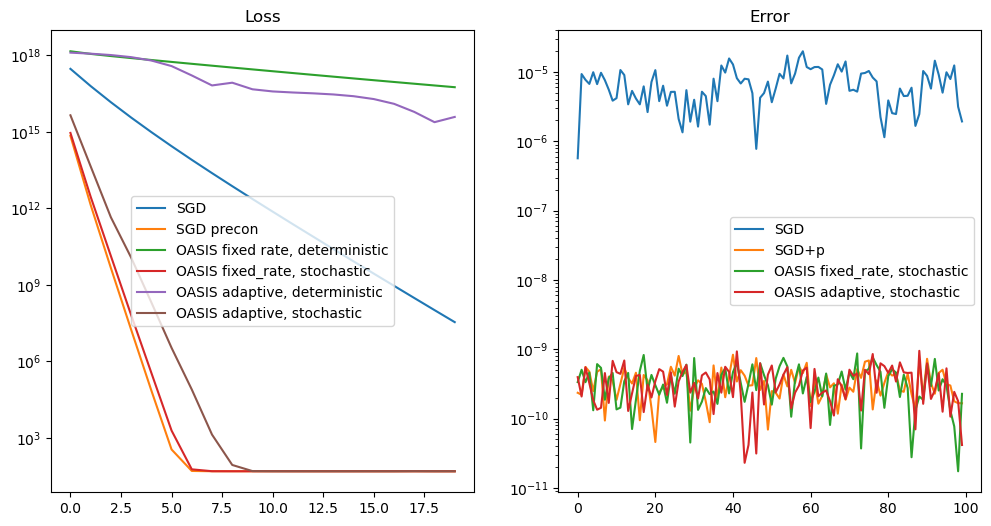

In [45]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(
    [
        "SGD",
        "SGD precon",
        "OASIS fixed rate, deterministic",
        "OASIS fixed_rate, stochastic",
        "OASIS adaptive, deterministic",
        "OASIS adaptive, stochastic",
    ]
)
# plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.semilogy(jnp.abs(x_sgd - x_gt))
plt.semilogy(jnp.abs(x_sgdp - x_gt))
# plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os - x_gt))
# plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa - x_gt))
# plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(
    ["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"]
)
plt.title("Error")

plt.rcParams["figure.figsize"] = 6, 6

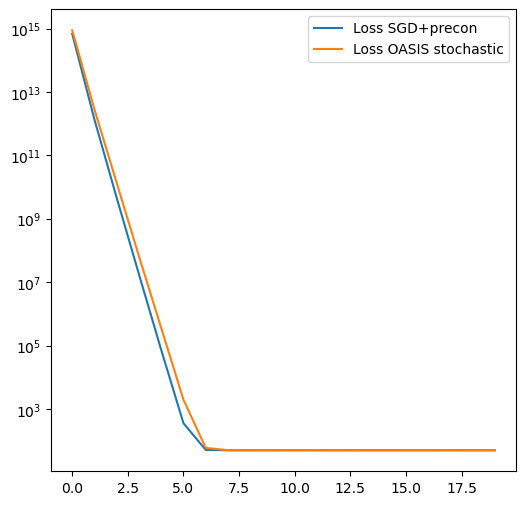

In [46]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [47]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))

50.16476461608576
34733909.62493039
50.21888190466406
5.509239780716754e+16
50.21474372575824
3773567758246569.0
50.25082328278186
